# Aggregating Time Series

## Introduction

XArray that can perform time-series aggregation with a simple and concise syntax using the [`resample()`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.resample.html) method. We can easily change the frequency of the original time-series using the desired aggregation method. This tutorial shows how to take a daily precipitation time-series and aggregate it to a monthly total precipitation time-series.

## Overview of the Task

We will download the gridded precipitation data from Indian Meterological department (IMD) using [`imdlib`](https://pypi.org/project/imdlib/), aggregate the daily time-series to monthly total rainfall and download the resulting rasters as GeoTIFF files.

**Input Data**:
* Gridded binary precipitation data from IMD.

**Output**:
* Monthly precipitation rasters as GeoTIFF files.

**Data and Software Credit**:
*   Pai D.S., Latha Sridhar, Rajeevan M., Sreejith O.P., Satbhai N.S. and Mukhopadhyay B., 2014: Development of a new high spatial resolution (0.25° X 0.25°)Long period (1901-2010) daily gridded rainfall data set over India and its comparison with existing data sets over the region; MAUSAM, 65, 1(January 2014), pp1-18.
* Nandi, S., Patel, P., and Swain, S. (2024). IMDLIB: An open-source library for retrieval, processing and spatiotemporal exploratory assessments of gridded meteorological observation datasets over India. Environmental Modelling and Software, 71 (105869), https://doi.org/10.1016/j.envsoft.2023.105869




## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install rioxarray imdlib

In [75]:
import os
import imdlib as imd
import rioxarray as xr
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

Download gridded binary datasets using [`imdlib`](https://pypi.org/project/imdlib/).

In [4]:
start_year = 2015
end_year = 2020
variable = 'rain' # other options are ('tmin'/ 'tmax')
data = imd.get_data(
    variable,
    start_year,
    end_year,
    fn_format='yearwise',
    file_dir=data_folder
)

Downloading: rain for year 2015
Downloading: rain for year 2016
Downloading: rain for year 2017
Downloading: rain for year 2018
Downloading: rain for year 2019
Downloading: rain for year 2020
Download Successful !!!


## Data Pre-Processing

First we read the data and create a XArray Dataset. The NoData values are stored as `-999` so we set those to NaN.

In [62]:
data = imd.open_data(
    variable,
    start_year,
    end_year,
    'yearwise',
    data_folder)

ds = data.get_xarray()
ds = ds.where(ds['rain'] != -999.)
ds

<xarray.Dataset> Size: 305MB
Dimensions:  (time: 2192, lat: 129, lon: 135)
Coordinates:
  * lat      (lat) float64 1kB 6.5 6.75 7.0 7.25 7.5 ... 37.75 38.0 38.25 38.5
  * lon      (lon) float64 1kB 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
  * time     (time) datetime64[ns] 18kB 2015-01-01 2015-01-02 ... 2020-12-31
Data variables:
    rain     (time, lat, lon) float64 305MB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.7
    title:        IMD gridded data
    source:       https://imdpune.gov.in/
    history:      2025-04-08 15:51:41.595289 Python
    references:   
    comment:      
    crs:          epsg:4326

## Aggregating Data

The input data containsdaily precipitation values. We want to aggregate these to monthly totals. XArray allows specifying the target frequency using a concise [frequncy string](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) from Pandas. The string **1MS** creates a time-series grouping from **Month Start** as **1** month intervals. We use `sum()` after resampling to calculate the monthly totals.

The result is a XArray Dataset with 12 time-steps for each year.

In [68]:
ds_monthly = ds.resample(time='1MS').sum()

## Plotting the time-series

Select the `rain` variable.

In [53]:
da_monthly = ds_monthly['rain']

We can extract the time-series at a specific X,Y coordinate. As our coordinates may not exactly match the DataArray coords, we use the `interp()` method to get the `nearest` value.

In [44]:
coordinate = (13.16, 77.35) # Lat/Lon
time_series = da_monthly \
  .interp(lat=coordinate[0], lon=coordinate[1], method='nearest')

Let's plot a time-series chart.

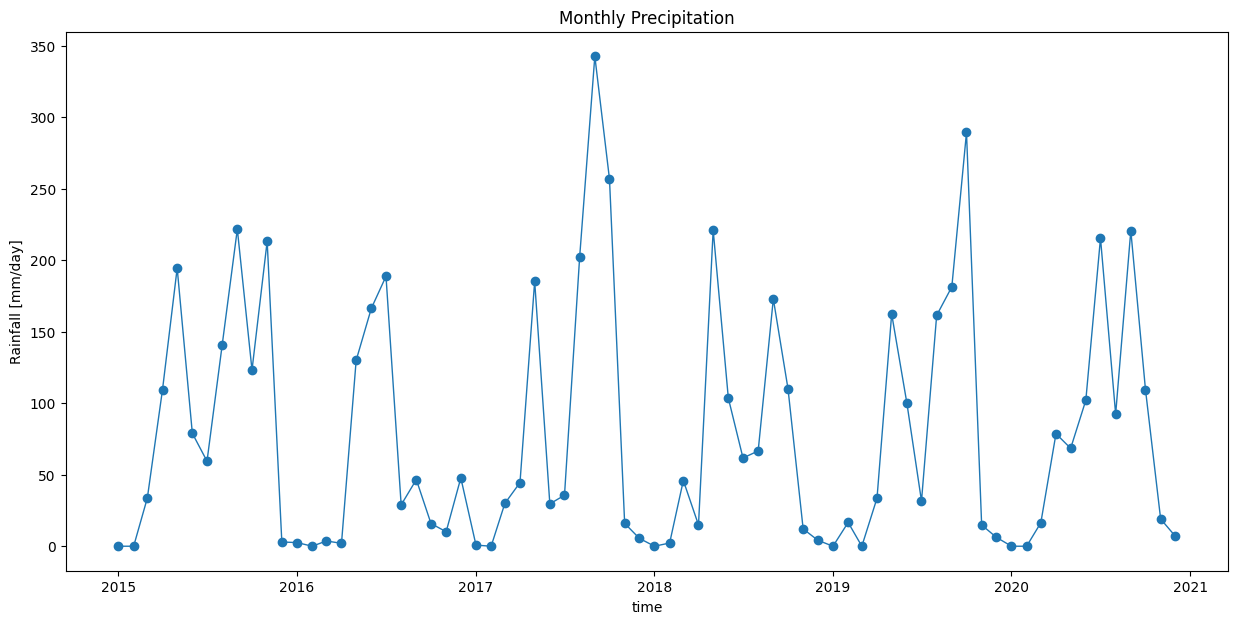

In [45]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

time_series.plot.line(
    ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
ax.set_title('Monthly Precipitation')
plt.show()


## Export Monthly Images as GeoTIFFs

In [ ]:
for time in da_monthly.time.values:
  image = da_monthly.sel(time=time)
  # transform the image to suit rioxarray format
  image = image \
    .rio.write_crs('EPSG:4326') \
    .rio.set_spatial_dims('lon', 'lat')
  date = pd.to_datetime(time).strftime('%Y-%m')
  output_file = f'image_{date}.tif'
  output_path = os.path.join(output_folder, output_file)
  image.rio.to_raster(output_path, driver='COG')
  print('Wrote file:', output_path)

----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>